In [1]:
from func.utils import get_model_output_id_wnid_class_dict # get mapping: format: {"Model Ouput ID": ["WNID", "Class"]}
from func.utils import get_imagenet_id_wnid_class_dict # get mapping: format: {"ImageNet ID": ["WNID", "class"]}, e.g. {..."233": ['n02106382', 'Bouvier_des_Flandres'], ...}
from func.utils import map_model_id_to_imagenet_id, map_imagenet_id_to_model_id # mapping funcs

from func.utils import save_obj, load_obj, preprocess_image, get_pretrained_model

from func.saliency_maps import conduct_saliency_map_method, GuidedBackprop, VanillaBackprop, SmoothGrad, GradCAM, GuidedGradCAM, IntegratedGradients, GradientxInput

from func.responsible_regions import load_responsible_regions_from_given_path, X_y_preparation, process_cat_saliency_map

from func.concept_classifier import get_linear_classifier, get_xgb_classifier, prediction

from func.show import load_feature_saliency_map_and_resized_img_for_show, show_concept_region_on_img

import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import pandas as pd
import gc
import time
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import copy
from skimage.transform import resize
import xml.etree.ElementTree as ET

In [2]:
# get the dict of ImageNet ID, WNID and class name
# format: {"ImageNet ID": ["WNID", "class"]}, e.g. {..."233": ['n02106382', 'Bouvier_des_Flandres'], ...}
imagenet_id_label=get_imagenet_id_wnid_class_dict(matfilepath = "imagenet_info/ILSVRC2012_meta.mat")

# get the dict of model output ID, WNID and class name
# format: {"Model Ouput ID": ["WNID", "Class"]}
modeloutput_id_label=get_model_output_id_wnid_class_dict(jsonfilepath = "imagenet_info/imagenet_label_index.json")

# get dict map model output ID to ImageNet ID
map_dict_model2imagenet=map_model_id_to_imagenet_id(imagenet_id_label, modeloutput_id_label)

# get ImageNet ID to dict map model output ID
map_dict_imagenet2model=map_imagenet_id_to_model_id(imagenet_id_label, modeloutput_id_label)

### show image classes

In [3]:
# only 1~1000 is valid
for idx in imagenet_id_label:
    print(str(idx)+": "+str(imagenet_id_label[idx]))

1: ['n02119789', 'kit fox, Vulpes macrotis']
2: ['n02100735', 'English setter']
3: ['n02110185', 'Siberian husky']
4: ['n02096294', 'Australian terrier']
5: ['n02102040', 'English springer, English springer spaniel']
6: ['n02066245', 'grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus']
7: ['n02509815', 'lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens']
8: ['n02124075', 'Egyptian cat']
9: ['n02417914', 'ibex, Capra ibex']
10: ['n02123394', 'Persian cat']
11: ['n02125311', 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor']
12: ['n02423022', 'gazelle']
13: ['n02346627', 'porcupine, hedgehog']
14: ['n02077923', 'sea lion']
15: ['n02110063', 'malamute, malemute, Alaskan malamute']
16: ['n02447366', 'badger']
17: ['n02109047', 'Great Dane']
18: ['n02089867', 'Walker hound, Walker foxhound']
19: ['n02102177', 'Welsh springer spaniel']
20: ['n02091134', 'whippet']
21: ['n02092002', 'Scottish deerhound, deerhound']
22: [

1621: ['n03100490', 'conveyance, transport']
1622: ['n04524313', 'vehicle']
1623: ['n03125870', 'craft']
1624: ['n02686568', 'aircraft']
1625: ['n03510583', 'heavier-than-air craft']
1626: ['n02691156', 'airplane, aeroplane, plane']
1627: ['n03666917', 'lighter-than-air craft']
1628: ['n04530566', 'vessel, watercraft']
1629: ['n02858304', 'boat']
1630: ['n03790230', 'motorboat, powerboat']
1631: ['n04158807', 'sea boat']
1632: ['n04244997', 'small boat']
1633: ['n04128837', 'sailing vessel, sailing ship']
1634: ['n04128499', 'sailboat, sailing boat']
1635: ['n04194289', 'ship']
1636: ['n02965300', 'cargo ship, cargo vessel']
1637: ['n03896103', 'passenger ship']
1638: ['n04552696', 'warship, war vessel, combat ship']
1639: ['n04348184', 'submersible, submersible warship']
1640: ['n03764276', 'military vehicle']
1641: ['n04099429', 'rocket, projectile']
1642: ['n04235291', 'sled, sledge, sleigh']
1643: ['n03678362', 'litter']
1644: ['n04019101', 'public transport']
1645: ['n04468005', '

### imagenet parent and child dict

In [4]:
imagenet_class_parent_and_child_dict = load_obj("imagenet_info/imagenet_class_dict")

### show ILSVRC annotations

In [5]:
anno_path = "/data/ImageNet_ILSVRC2012/val"

files = os.listdir(anno_path)
files.sort()
anno_files = []
for file in files:
    if file.split(".")[-1]=="xml":
        anno_files.append(file)

In [6]:
def get_bbox(anno_xml_file_path):
    tree = ET.parse(anno_xml_file_path)
    root = tree.getroot()
    
    boxes = []
    for item in root:
        for subitem in item:
            if subitem.tag == "name":
                temp_box = {}
                temp_box["name"] = subitem.text
            if subitem.tag == "bndbox":
                for subsubitem in subitem:
                    if subsubitem.tag == "xmin":
                        temp_box["xmin"] = int(subsubitem.text)
                    if subsubitem.tag == "ymin":
                        temp_box["ymin"] = int(subsubitem.text)
                    if subsubitem.tag == "xmax":
                        temp_box["xmax"] = int(subsubitem.text)
                    if subsubitem.tag == "ymax":
                        temp_box["ymax"] = int(subsubitem.text)        
                width = int(temp_box["xmax"]-temp_box["xmin"])
                height = int(temp_box["ymax"]-temp_box["ymin"])
                temp_box["width"]=width
                temp_box["height"]=height
                boxes.append(temp_box)
                del temp_box
    
    return boxes

show an img

In [7]:
boxes = get_bbox(anno_path+"/"+"ILSVRC2012_val_00050000.xml")
boxes

[{'name': 'n02437616',
  'xmin': 237,
  'ymin': 109,
  'xmax': 446,
  'ymax': 374,
  'width': 209,
  'height': 265},
 {'name': 'n02437616',
  'xmin': 175,
  'ymin': 89,
  'xmax': 474,
  'ymax': 342,
  'width': 299,
  'height': 253}]

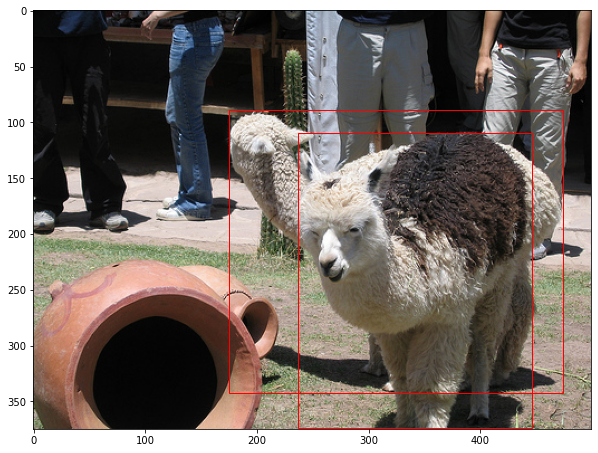

In [8]:
img_base_path = "/data/ImageNet_ILSVRC2012/val"

files = os.listdir(img_base_path)
files.sort()
img_files = []
for file in files:
    if file.split(".")[-1]=="JPEG":
        img_files.append(file)

img = Image.open(anno_path+"/"+"ILSVRC2012_val_00050000.JPEG")
img = np.asarray(img)
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(img)

for box in boxes:
    
    x = int(box["xmin"])
    y = int(box["ymin"])
    width = int(box["width"])
    height = int(box["height"])

    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

In [9]:
def get_img_and_box_by_idx(idx, anno_files, img_files, anno_base_path, img_base_path):
    assert anno_files[idx].split(".")[0] == img_files[idx].split(".")[0]
    
    img = Image.open(img_base_path+"/"+img_files[idx])
    img = np.asarray(img)
    boxes = get_bbox(anno_base_path+"/"+anno_files[idx])
    
    return img, boxes

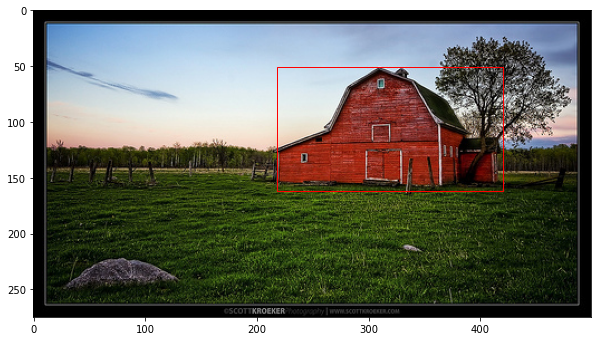

In [10]:
idx = 233
img, boxes = get_img_and_box_by_idx(idx, anno_files, img_files, anno_path, img_base_path)

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(img)

for box in boxes:
    
    x = int(box["xmin"])
    y = int(box["ymin"])
    width = int(box["width"])
    height = int(box["height"])

    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

In [11]:
# label of val dataset
val_labels = np.loadtxt("/data/ImageNet_ILSVRC2012/devkit/data/ILSVRC2012_validation_ground_truth.txt")

In [12]:
imagenet_id_label[str(int(val_labels[idx]))]

['n02793495', 'barn']

In [13]:
imagenet_class_parent_and_child_dict = load_obj("imagenet_info/imagenet_class_dict")

chosen_ID = 1119
children = []

print("For (ImageNet ID: "+str(chosen_ID)+") "+imagenet_class_parent_and_child_dict[chosen_ID]["words"])

def find_children(current_ID):
    if len(imagenet_class_parent_and_child_dict[current_ID]["children"])==0:
        print("find child (ImageNet ID: "+str(current_ID)+") "+imagenet_class_parent_and_child_dict[current_ID]["words"])
        children.append(current_ID)
        return
    else:
        for c in imagenet_class_parent_and_child_dict[current_ID]["children"]:
            find_children(c)

find_children(chosen_ID)

For (ImageNet ID: 1119) animal, animate being, beast, brute, creature, fauna
find child (ImageNet ID: 601) trilobite
find child (ImageNet ID: 611) centipede
find child (ImageNet ID: 602) harvestman, daddy longlegs, Phalangium opilio
find child (ImageNet ID: 603) scorpion
find child (ImageNet ID: 604) black and gold garden spider, Argiope aurantia
find child (ImageNet ID: 605) barn spider, Araneus cavaticus
find child (ImageNet ID: 606) garden spider, Aranea diademata
find child (ImageNet ID: 607) black widow, Latrodectus mactans
find child (ImageNet ID: 608) tarantula
find child (ImageNet ID: 609) wolf spider, hunting spider
find child (ImageNet ID: 610) tick
find child (ImageNet ID: 612) isopod
find child (ImageNet ID: 619) crayfish, crawfish, crawdad, crawdaddy
find child (ImageNet ID: 620) hermit crab
find child (ImageNet ID: 613) Dungeness crab, Cancer magister
find child (ImageNet ID: 614) rock crab, Cancer irroratus
find child (ImageNet ID: 615) fiddler crab
find child (ImageNet 

In [14]:
int(val_labels[idx]) in children

False

### load ILSVRC image

In [15]:
idx = 1996
im_resize = (224,224)
img, boxes = get_img_and_box_by_idx(idx, anno_files, img_files, anno_path, img_base_path)
preprocessed_img_tensor, resized_img = preprocess_image(img, im_resize)

In [16]:
boxes

[{'name': 'n02094114',
  'xmin': 130,
  'ymin': 45,
  'xmax': 348,
  'ymax': 299,
  'width': 218,
  'height': 254}]

In [17]:
def get_resize_box(box, org_img_shape, new_img_shape):
    new_x = int(box["xmin"] * new_img_shape[1] / org_img_shape[1])
    new_y = int(box["ymin"] * new_img_shape[0] / org_img_shape[0])
    new_width = int(box["width"] * new_img_shape[1] / org_img_shape[1])
    new_height = int(box["height"] * new_img_shape[0] / org_img_shape[0])
    
    return {"name": box["name"], "xmin":new_x, "ymin":new_y, "width":new_width, "height":new_height}

def get_resize_boxes(boxes, org_img_shape, new_img_shape):
    resize_boxes = []
    for box in boxes:
        resize_boxes.append(get_resize_box(box, org_img_shape, new_img_shape))
    return resize_boxes

def get_mask_of_box(box,img_shape):
    mask_of_box = np.zeros(img_shape)
    mask_of_box[box["ymin"]:box["ymin"]+box["height"]+1,box["xmin"]:box["xmin"]+box["width"]+1] = 1
    return mask_of_box

def get_mask_of_boxes(boxes,img_shape):
    mask_of_boxes = np.zeros(img_shape)
    for box in boxes:
        mask = get_mask_of_box(box,img_shape)
        mask_of_boxes[mask>0] = 1
    return mask_of_boxes

In [18]:
new_boxes = get_resize_boxes(boxes, img.shape, im_resize)
mask_of_boxes = get_mask_of_boxes(new_boxes, im_resize)

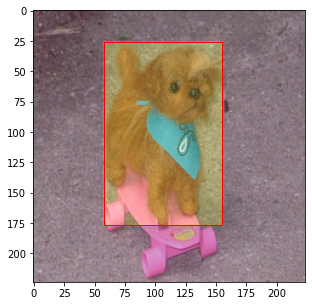

In [19]:
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(resized_img)
ax.imshow(mask_of_boxes, alpha=0.2)

for box in new_boxes:
    
    x = int(box["xmin"])
    y = int(box["ymin"])
    width = int(box["width"])
    height = int(box["height"])

    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

### load model (ResNet50 as example)

In [20]:
model_name = "resnet50"

which_layer_to_hook = ["layer3.5"]

salient_method = GuidedBackprop

pretrained_model = get_pretrained_model(model_name, True)

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

print("model structure:\n"+str(pretrained_model))

model structure:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [21]:
saliency_map, feature_map, _ = conduct_saliency_map_method(salient_method, preprocessed_img_tensor, None,
                                                           pretrained_model, which_layer_to_hook=which_layer_to_hook,
                                                           device=device)

Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [22]:
chosen_layer = which_layer_to_hook[0]

### load concept classifier

In [23]:
clf_dict = load_obj("output/concept_clf/concept_clf_whole_resnet50")
clf = clf_dict["clf"]
print(clf_dict["info"])

{'name': 'whole classifier', 'model': 'resnet50', 'layer': 'layer3.5'}


In [24]:
pred = prediction(clf, feature_map[chosen_layer])

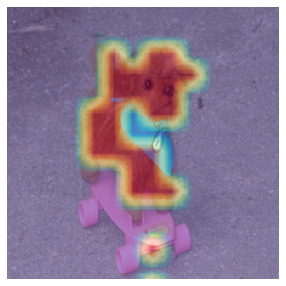

In [25]:
show_concept_region_on_img(resized_img, pred, figsize=(5,5))

### calculate acc

In [26]:
def get_the_box_of_localization(mask):
    locs = np.where(mask>0)
    max_y = np.max(locs[0])
    max_x = np.max(locs[1])
    min_y = np.min(locs[0])
    min_x = np.min(locs[1])
    
    mask_box = np.zeros(mask.shape)
    mask_box[min_y:max_y+1, min_x:max_x+1] = 1
    
    return mask_box

def get_iou(gt, pred):
    return np.sum(np.multiply(pred, gt)) / np.sum(np.array(gt+pred>0, dtype=np.int))

def cal_iou_of_gt_and_pred_box(gt_box, pred_box):
    resize_pred_box = np.array(resize(np.array(pred_box, dtype=float), (gt_box.shape[0], gt_box.shape[1]))>0, dtype=int)
    return get_iou(gt_box, resize_pred_box)

In [27]:
cal_iou_of_gt_and_pred_box(mask_of_boxes, get_the_box_of_localization(pred))

/tmp/ipykernel_49011/706960537.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.sum(np.multiply(pred, gt)) / np.sum(np.array(gt+pred>0, dtype=np.int))


0.665